In [1]:
from simulation_code.load_model import load_model_from_excel
from simulation_code.tissue_model import acuity_source

import matplotlib.pyplot as plt
import numpy as np
import os
from itertools import product

# Set mu_a values outside range available in tables to 0.
os.environ["PA_SIM_EXTRAPOLATE"] = "0"

FAST_DEMO_MODE = True
# for fast demo mode, we only run a single wavelength and one oxygenation.

# These parameters will be used for MCX simulation.
nx, ny, nz = 668, 400, 300
dx = 0.06  # mm

# Wavelengths to get reflectance measurements at.
WAVELENGTHS = np.arange(700, 920, 20)
if FAST_DEMO_MODE:
    WAVELENGTHS = WAVELENGTHS[:1]

# Artery blood oxygenations.
OXYGENATIONS = np.linspace(0, 1, 11)
if FAST_DEMO_MODE:
    OXYGENATIONS = OXYGENATIONS[:1]

# Melanosome volume fractions: varied logarithmically.
mvfs = np.logspace(np.log10(0.02), np.log10(0.4), 6)
if FAST_DEMO_MODE:
    mvfs = mvfs[:1]

# The six simulation parameters are assigned to the Fitzpatrick scale.
fps = ["I", "II", "III", "IV", "V", "VI"]

Make the tissue definitions:

In [2]:
i = 0
for oxy, mvf in product(OXYGENATIONS, mvfs):
    tissue_model = load_model_from_excel(
        "simulation_specification/single_vessel_forearm_tissue_model.xlsx",
        nx,
        ny,
        nz,
        dx,
        tissue_cz=-nz * dx / 3,
        variations=[
            ("Epidermis", {"MelanosomeVolumeFraction": mvf}),
            ("Artery", {"BloodOxygenation": oxy}),
        ],
    )

    settings = {"artery_oxygenation": oxy, "mvf": mvf}

    # capture means we don't print out all the MCX information
    m = tissue_model.run_mcx(
        WAVELENGTHS,
        acuity_source(tissue_model),
        middle_slice_only=True,
        gpu_device=2,
    )

    m.update(settings)

    # Load the detection geometry from NumPy file.
    geometry = np.load("../data/acuity_geometry.npz")["geom"]
    geometry[:, 2] -= 8e-3
    if not FAST_DEMO_MODE:
        np.savez(
            f"../data/simulations/melanosome_allox_{str(i).zfill(3)}",
            **m,
            r0=tissue_model.r_0,
            dx_mm=tissue_model.dx_mm,
            n=tissue_model.n,
            geom=geometry,
        )
    i += 1

###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2022 Qianqian Fang <q.fang at neu.edu>          #
#                             http://mcx.space/                               #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
$Rev::      $v2022.10$Date::                       $ by $Author::             $
###############################################################################
- variant name: [Fermi] compiled by nvcc

To illustrate the simulation volume, we can make a plot of the structures:

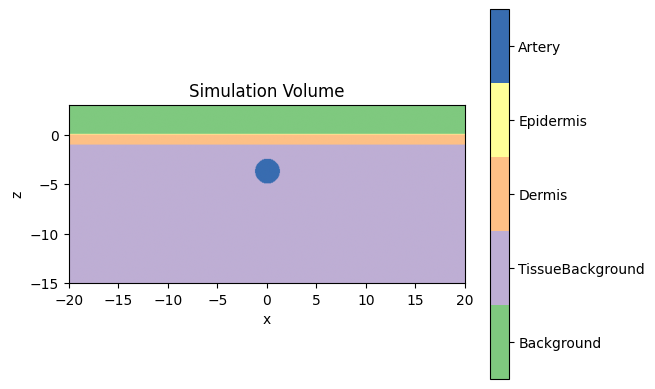

In [3]:
fig, ax, cbar = tissue_model.imshow()
plt.title("Simulation Volume")
labels = []
positions = []
for i, t in enumerate(tissue_model.tissues):
    labels.append(t.name)
    positions.append(i)
cbar.set_ticks(positions, labels=labels)
plt.show()

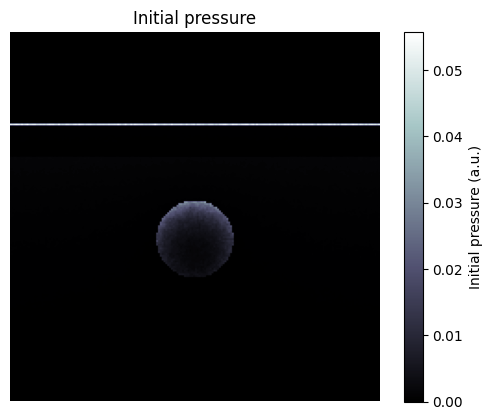

In [4]:
plt.imshow(
    m["p0"][0].T[100:300, 668 // 2 - 100: 668 // 2 + 100],
    origin="lower",
    cmap="bone",
)
plt.axis("off")
plt.title("Initial pressure")
plt.colorbar(label="Initial pressure (a.u.)")
plt.show()